# Final Project: Predicting Future Sales

## 1. Import all required libraries and Load data

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from itertools import product
from tqdm import tqdm
from IPython.display import display, HTML
import seaborn as sns

InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
  
    

Load data from "inputs" folder

In [2]:

items_df = pd.read_csv("./inputs/items.csv")
item_cat_df = pd.read_csv("./inputs/item_categories.csv")
sales_train_df = pd.read_csv("./inputs/sales_train_v2.csv")
shops_df = pd.read_csv("./inputs/shops.csv")
test_df = pd.read_csv("./inputs/test.csv")
sample_submission_df = pd.read_csv("./inputs/sample_submission.csv")



## 2. Exploratory Data Analysis

In [3]:
#Lets take  a look at contents of all tabels
items_df.shape
items_df.describe()

item_cat_df.shape
item_cat_df.describe()

sales_train_df.shape
sales_train_df.describe()
sales_train_df.head()

shops_df.shape
shops_df.describe()

test_df.shape
test_df.describe()

sample_submission_df.shape
sample_submission_df.describe()

(22170, 3)

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


(84, 2)

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


(2935849, 6)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


(60, 2)

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


(214200, 3)

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


(214200, 2)

,ID,item_cnt_month
count,214200.000000,214200.0
mean,107099.500000,0.5
std,61834.358168,0.0
min,0.000000,0.5
25%,53549.750000,0.5
50%,107099.500000,0.5
75%,160649.250000,0.5
max,214199.000000,0.5


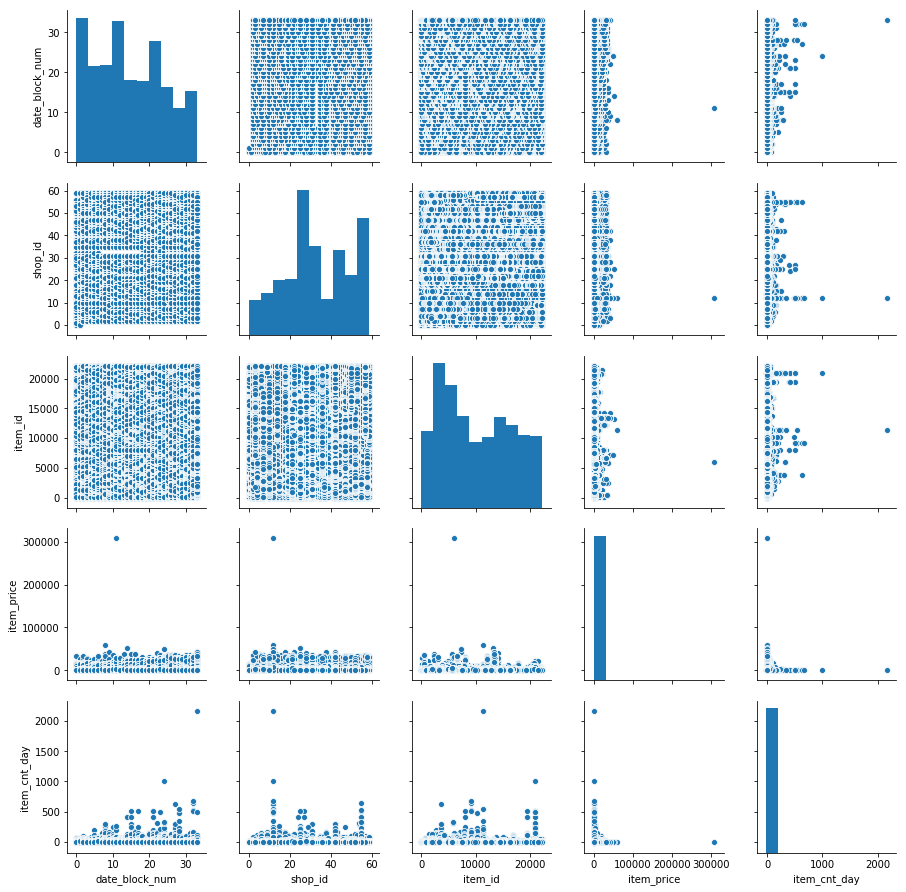

In [26]:
sns.pairplot(sales_train_df)

As we can observe from above plots there are some outliers in item_cnt_day and item_price

In [7]:

sales_train_df[['day','month','year']] = sales_train_df.date.str.split('.',expand=True)
sales_train_df['date'] = pd.to_datetime(sales_train_df['date'], format = '%d.%m.%Y')
sales_train_df['sales'] = sales_train_df.item_price * sales_train_df.item_cnt_day

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


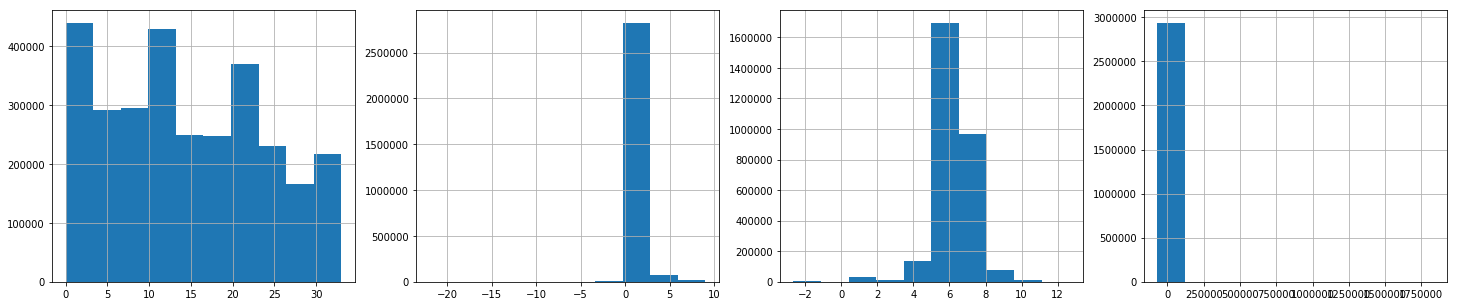

In [8]:
fig, axes = plt.subplots(1,4, figsize=(25,5))
sales_train_df.date_block_num.hist(ax=axes[0])
sales_train_df[sales_train_df['item_cnt_day'] < 10].item_cnt_day.hist(ax=axes[1])
np.log(sales_train_df['item_price']).hist(ax=axes[2])
sales_train_df.sales.hist(ax=axes[3])

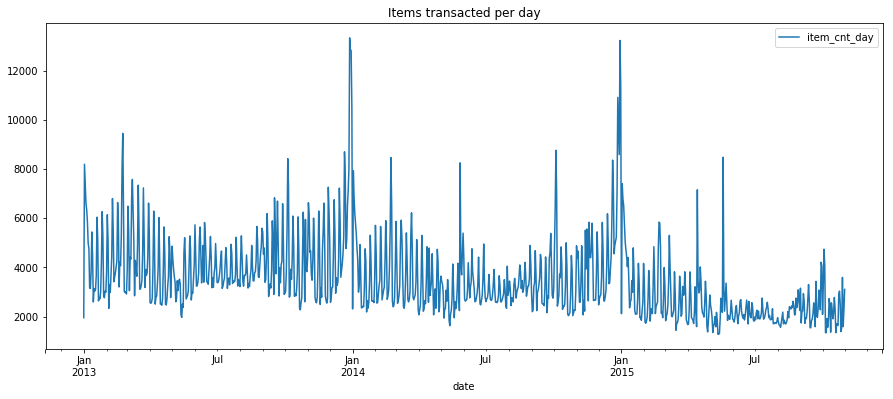

In [10]:
sales_train_df.groupby('date').agg({"item_cnt_day": "sum"}).plot(figsize=(15,6),title="Items transacted per day")

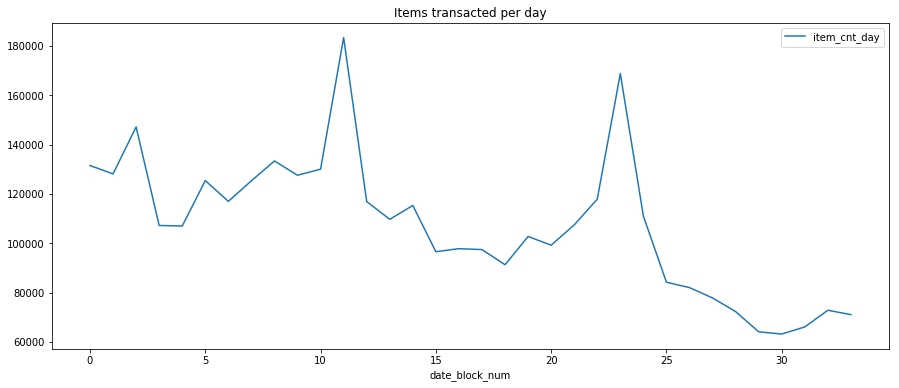

In [12]:
sales_train_df.groupby('date_block_num').agg({"item_cnt_day": "sum"}).plot(figsize=(15,6),title="Items transacted per day")

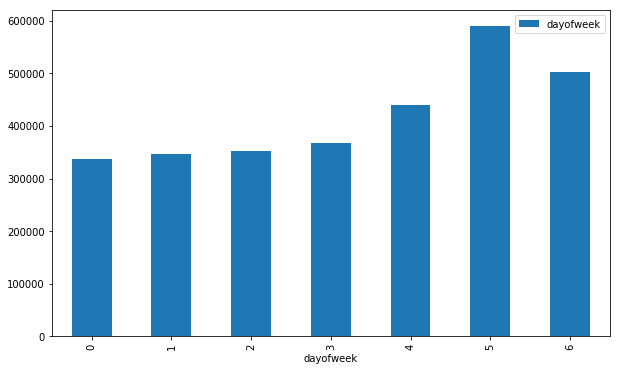

In [16]:
#We can clearly see a rise in sales on Friday-Sunday

sales_train_df['dayofweek'] = sales_train_df.date.dt.dayofweek # The day of the week with Monday=0, Sunday=6
sales_train_df.groupby("dayofweek").agg({"dayofweek": "count"}).plot.bar(figsize=(10, 6));


Let's take a look at outliers in item price and cnt_day 

<Figure size 720x288 with 0 Axes>

(-100, 3000)

<Figure size 720x288 with 0 Axes>

(-1.0, 338778.0)

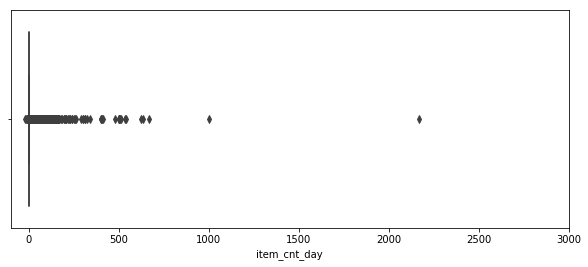

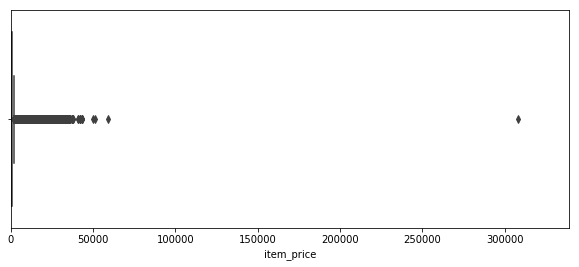

In [20]:

plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales_train_df.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(sales_train_df.item_price.min(), sales_train_df.item_price.max()*1.1)
sns.boxplot(x=sales_train_df.item_price)


#### Remove outliers from item_price and item_cnt_day

In [4]:
sales_train_df[sales_train_df['item_id'] == 11373][['item_price']].sort_values(['item_price'])
sales_train_df[sales_train_df['item_id'] == 11365].sort_values(['item_price'])

# Correcting sales_train_df values
sales_train_df['item_price'][2909818] = np.nan
sales_train_df['item_cnt_day'][2909818] = np.nan
sales_train_df['item_price'][2909818] = sales_train_df[(sales_train_df['shop_id'] ==12) & (sales_train_df['item_id'] == 11373) & (sales_train_df['date_block_num'] == 33)]['item_price'].median()
sales_train_df['item_cnt_day'][2909818] = round(sales_train_df[(sales_train_df['shop_id'] ==12) & (sales_train_df['item_id'] == 11373) & (sales_train_df['date_block_num'] == 33)]['item_cnt_day'].median())
sales_train_df['item_price'][885138] = np.nan
sales_train_df['item_price'][885138] = sales_train_df[(sales_train_df['item_id'] == 11365) & (sales_train_df['shop_id'] ==12) & (sales_train_df['date_block_num'] == 8)]['item_price'].median()


sales_train_df = sales_train_df.merge(test_df[['shop_id']].drop_duplicates(), how = 'inner')
sales_train_df['date'] = pd.to_datetime(sales_train_df['date'], format = '%d.%m.%Y')

,item_price
2909818,0.908714
2257993,38.500000
2048642,71.000000
1058343,72.200000
2462729,75.454545
1398729,76.000000
2608354,76.083333
2257974,77.500000
2626184,79.677419
2731663,80.000000


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1651714,16.05.2014,16,12,11365,124.000000,5.0
2805487,21.08.2015,31,12,11365,170.000000,2.0
1330776,13.01.2014,12,12,11365,180.000000,3.0
1398688,25.02.2014,13,12,11365,194.000000,5.0
661581,05.07.2013,6,12,11365,230.000000,4.0
2731490,30.07.2015,30,12,11365,230.000000,1.0
1398683,06.02.2014,13,12,11365,246.666667,9.0
2626123,21.05.2015,28,12,11365,248.333333,6.0
2608316,16.04.2015,27,12,11365,249.333333,15.0
1058265,29.11.2013,10,12,11365,260.867925,53.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy o

### 3. Feature Engineering and data aggregation

 For every month we create a grid from all shops/items combinations from that month


In [5]:

grid = []

for block_num in sales_train_df['date_block_num'].unique():

    cur_shops = sales_train_df[sales_train_df['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales_train_df[sales_train_df['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#Convert the grid into pandas dataframe
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [6]:
def dcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int16)

    return df

In [7]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

sales_train_df['item_cnt_day'] = sales_train_df['item_cnt_day'].clip(0,20)

gb_cnt = sales_train_df.groupby(index_cols)['item_cnt_day'].agg(['sum']).reset_index().rename(columns = {'sum': 'item_cnt_month'})

gb_cnt['item_cnt_month'] = gb_cnt['item_cnt_month'].clip(0,20).astype(np.int)

#join aggregated data to the grid
train = pd.merge(grid,gb_cnt,how='left',on=index_cols).fillna(0)
train['item_cnt_month'] = train['item_cnt_month'].astype(int)

train = dcast_dtypes(train)

#sort the data
train.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

## Sanity check
sales_train_df['item_cnt_day'].sum()
train['item_cnt_month'].sum()
gb_cnt['item_cnt_month'].sum()

train.head()

2934456.0

2671279

2671279

,shop_id,item_id,date_block_num,item_cnt_month
84203,2,19,0,0
86531,2,27,0,1
88912,2,28,0,0
87693,2,29,0,0
83623,2,32,0,0


In [8]:

train = train.merge(items_df[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')
test = test_df.merge(items_df[['item_id', 'item_category_id']], on = ['item_id'], how = 'left')


Recode item_category_name using translations from google translate

In [9]:
l_cat = list(item_cat_df.item_category_name)

for ind in range(0,1):
    l_cat[ind] = 'PC - Headsets / Headphones'

for ind in range(1,7):
    l_cat[ind] = 'Accessories'

l_cat[8] = 'Tickets (Digital)'

l_cat[9] = 'Delivery of goods'

for ind in range(10,17):
    l_cat[ind] = 'Game Consoles'

for ind in range(18,24):
    l_cat[ind] = 'Games'

l_cat[25] = 'Accessories for games'
l_cat[26] = 'Android Games'

for ind in range(27,31):
    l_cat[ind] = 'PC games'

for ind in range(32,36):
    l_cat[ind] = 'Payment Card'

for ind in range(37,41):
    l_cat[ind] = 'Movie'

for ind in range(42,54):
    l_cat[ind] = 'Books'

for ind in range(55,60):
    l_cat[ind] = 'Music'

for ind in range(61,72):
    l_cat[ind] = 'Gifts'

for ind in range(73,78):
    l_cat[ind] = 'Softwares'

for ind in range(79,80):
    l_cat[ind] = 'Service'

for ind in range(81,82):
    l_cat[ind] = 'Cleaning'

l_cat[83] = 'Batteries'


from sklearn import preprocessing

lb = preprocessing.LabelEncoder()

lb.fit_transform(l_cat)

item_cat_df['item_cat_id_fix'] = lb.fit_transform(l_cat)



array([12,  0,  0,  0,  0,  0,  0, 18, 17,  6,  7,  7,  7,  7,  7,  7,  7,
       19,  8,  8,  8,  8,  8,  8, 20,  1,  2, 13, 13, 13, 13, 21, 14, 14,
       14, 14, 22, 10, 10, 10, 10, 23,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4, 24, 11, 11, 11, 11, 11, 25,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9, 26, 16, 16, 16, 16, 16, 27, 15, 28,  5, 29,  3],
      dtype=int64)

In [10]:
train = train.merge(item_cat_df[['item_cat_id_fix', 'item_category_id']], on = ['item_category_id'], how = 'left')

test = test.merge(item_cat_df[['item_cat_id_fix', 'item_category_id']], on = ['item_category_id'], how = 'left')

#### Add mean-encoded features
This step also checks for coorelation of mean encoded features with target variable, to ensure there is no target leakage

In [11]:
Validation = False

In [12]:

# For Trainset
Target = 'item_cnt_month'
global_mean =  train[Target].mean()
y_tr = train[Target].values

mean_encoded_col = ['shop_id', 'item_id', 'item_category_id', 'item_cat_id_fix']

for col in tqdm(mean_encoded_col):

    col_tr = train[[col] + [Target]]
    corrcoefs = pd.DataFrame(columns = ['Cor'])

    #1 Mean encodings - K-Fold Schema
    from sklearn import model_selection

    kf = model_selection.KFold(5, shuffle = False, random_state = 0)

    col_tr[col + '_cnt_month_mean_Kfold'] = global_mean

    for tr_ind, val_ind in kf.split(col_tr):
        X_tr, X_val = col_tr.iloc[tr_ind], col_tr.iloc[val_ind]
        means = X_val[col].map(X_tr.groupby(col)[Target].mean())
        X_val[col + '_cnt_month_mean_Kfold'] = means
        col_tr.iloc[val_ind] = X_val        
        

    col_tr.fillna(global_mean, inplace = True)
    corrcoefs.loc[col + '_cnt_month_mean_Kfold'] = np.corrcoef(y_tr, col_tr[col + '_cnt_month_mean_Kfold'])[0][1]

    #2 Mean encodings - Leave-one-out scheme
    item_id_target_sum = col_tr.groupby(col)[Target].sum()
    item_id_target_count = col_tr.groupby(col)[Target].count()

    col_tr[col + '_cnt_month_sum'] = col_tr[col].map(item_id_target_sum)
    col_tr[col + '_cnt_month_count'] = col_tr[col].map(item_id_target_count)

    col_tr[col + '_target_mean_LOO'] = (col_tr[col + '_cnt_month_sum'] - col_tr[Target]) / (col_tr[col + '_cnt_month_count'] - 1)
    col_tr.fillna(global_mean, inplace = True)

    corrcoefs.loc[col + '_target_mean_LOO'] = np.corrcoef(y_tr, col_tr[col + '_target_mean_LOO'])[0][1]


    #3 Mean encodings - Smoothing
    item_id_target_mean = col_tr.groupby(col)[Target].mean()
    item_id_target_count = col_tr.groupby(col)[Target].count()
    col_tr[col + '_cnt_month_mean'] = col_tr[col].map(item_id_target_mean)
    col_tr[col + '_cnt_month_count'] = col_tr[col].map(item_id_target_count)
    alpha = 100

    col_tr[col + '_cnt_month_mean_Smooth'] = (col_tr[col + '_cnt_month_mean'] *  col_tr[col + '_cnt_month_count'] + global_mean * alpha) / (alpha + col_tr[col + '_cnt_month_count'])

    col_tr[col + '_cnt_month_mean_Smooth'].fillna(global_mean, inplace=True)

    corrcoefs.loc[col + '_cnt_month_mean_Smooth'] = np.corrcoef(y_tr, col_tr[col + '_cnt_month_mean_Smooth'])[0][1]


    #4 Mean encodings - Expanding mean scheme
    cumsum = col_tr.groupby(col)[Target].cumsum() - col_tr[Target]
    sumcnt = col_tr.groupby(col).cumcount()
    col_tr[col + '_cnt_month_mean_Expanding'] = cumsum / sumcnt
    col_tr[col + '_cnt_month_mean_Expanding'].fillna(global_mean, inplace=True)
    corrcoefs.loc[col + '_cnt_month_mean_Expanding'] = np.corrcoef(y_tr, col_tr[col + '_cnt_month_mean_Expanding'])[0][1]
   
    
    train = pd.concat([train, col_tr[corrcoefs['Cor'].idxmax()]], axis = 1)

    print(corrcoefs.sort_values('Cor'))

  0%|          | 0/4 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

                                       Cor
shop_id_cnt_month_mean_Kfold      0.173370
shop_id_target_mean_LOO           0.175547
shop_id_cnt_month_mean_Smooth     0.175572
shop_id_cnt_month_mean_Expanding  0.175746


 25%|██▌       | 1/4 [00:11<00:35, 11.75s/it]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                                       Cor
item_id_cnt_month_mean_Kfold      0.315862
item_id_cnt_month_mean_Smooth     0.479840
item_id_target_mean_LOO           0.481937
item_id_cnt_month_mean_Expanding  0.565646


 50%|█████     | 2/4 [00:25<00:24, 12.28s/it]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


                                                Cor
item_category_id_cnt_month_mean_Kfold      0.274072
item_category_id_cnt_month_mean_Smooth     0.292732
item_category_id_target_mean_LOO           0.292778
item_category_id_cnt_month_mean_Expanding  0.296104


 75%|███████▌  | 3/4 [00:44<00:14, 14.31s/it]C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


                                               Cor
item_cat_id_fix_cnt_month_mean_Kfold      0.207511
item_cat_id_fix_target_mean_LOO           0.218750
item_cat_id_fix_cnt_month_mean_Smooth     0.218758
item_cat_id_fix_cnt_month_mean_Expanding  0.219135


100%|██████████| 4/4 [01:02<00:00, 15.33s/it]


If Validation = False, full training set is used for modelling

In [14]:
if Validation == False:
    test['date_block_num'] = 34
    all_data = pd.concat([train, test], axis = 0)
    all_data = all_data.drop(columns = ['ID'])

else:
    all_data = train

all_data = dcast_dtypes(all_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


#### Creating item/shop pair lags lag-based features 

In [15]:

index_cols = ['shop_id', 'item_id', 'item_category_id', 'item_cat_id_fix', 'date_block_num']

cols_to_rename = list(all_data.columns.difference(index_cols))

print(cols_to_rename)

shift_range = [1, 2, 3, 4, 12]

for month_shift in tqdm(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)
    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

all_data = all_data[all_data['date_block_num'] >= 12] # Don't use old data from year 2013

lag_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]

all_data = dcast_dtypes(all_data)

['item_cat_id_fix_cnt_month_mean_Expanding', 'item_category_id_cnt_month_mean_Expanding', 'item_cnt_month', 'item_id_cnt_month_mean_Expanding', 'shop_id_cnt_month_mean_Expanding']


100%|██████████| 5/5 [01:12<00:00, 13.82s/it]


#### Add date features


In [16]:
dates_train = sales_train_df[['date', 'date_block_num']].drop_duplicates()
dates_test = dates_train[dates_train['date_block_num'] == 34-12]

dates_test['date_block_num'] = 34
dates_test['date'] = dates_test['date'] + pd.DateOffset(years=1)
dates_test.dtypes
dates_all = pd.concat([dates_train, dates_test])


dates_all['dow'] = dates_all['date'].dt.dayofweek
dates_all['year'] = dates_all['date'].dt.year
dates_all['month'] = dates_all['date'].dt.month
dates_all = pd.get_dummies(dates_all, columns=['dow'])

dow_col = ['dow_' + str(x) for x in range(7)]

date_features = dates_all.groupby(['year', 'month', 'date_block_num'])[dow_col].agg('sum').reset_index()

date_features['days_of_month'] = date_features[dow_col].sum(axis=1)

date_features['year'] = date_features['year'] - 2013



date_features = date_features[['month', 'year', 'days_of_month', 'date_block_num']]

all_data = all_data.merge(date_features, on = 'date_block_num', how = 'left')

date_columns = date_features.columns.difference(set(index_cols))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


date              datetime64[ns]
date_block_num             int64
dtype: object

#### Scale feature columns

In [17]:
from sklearn.preprocessing import StandardScaler

train = all_data[all_data['date_block_num']!= all_data['date_block_num'].max()]

test = all_data[all_data['date_block_num']== all_data['date_block_num'].max()]

sc = StandardScaler()

to_drop_cols = ['date_block_num']

feature_columns = list(set(lag_cols + index_cols + list(date_columns)).difference(to_drop_cols))

train[feature_columns] = sc.fit_transform(train[feature_columns])

test[feature_columns] = sc.transform(test[feature_columns])

all_data = pd.concat([train, test], axis = 0)
all_data = dcast_dtypes(all_data)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int16, float32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int16, float32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

## 4. Modelling

We create 3 first level models, results from these first level models are passed onto level 2 models for ensabling

In [18]:
num_first_level_models = 3
SEED = 777
dates = all_data['date_block_num']

last_block = dates.max()

print('Test `date_block_num` is %d' % last_block)
print(feature_columns)


scoringMethod = 'r2' 
from sklearn.metrics import mean_squared_error 
from math import sqrt


# Train meta-features M = 15 (12 + 15 = 27)
mon_to_meta_features = range(27,last_block +1)
mask = dates.isin(mon_to_meta_features)

Target = 'item_cnt_month'

y_all_level2 = all_data[Target][mask].values
X_all_level2 = np.zeros([y_all_level2.shape[0], num_first_level_models])


# Now fill `X_train_level2` with metafeatures

slice_start = 0

for cur_block_num in tqdm(mon_to_meta_features):

    print('-' * 50)
    print('Start training for month%d'% cur_block_num)

    cur_X_train = all_data.loc[dates <  cur_block_num][feature_columns]
    cur_X_test =  all_data.loc[dates == cur_block_num][feature_columns]


    cur_y_train = all_data.loc[dates <  cur_block_num, Target].values
    cur_y_test =  all_data.loc[dates == cur_block_num, Target].values

    #Create Numpy arrays of train, test and target dataframes to feed into models
    train_x = cur_X_train.values
    train_y = cur_y_train.ravel()

    test_x = cur_X_test.values
    test_y = cur_y_test.ravel()

    preds = []

    from sklearn.linear_model import (LinearRegression, SGDRegressor)
    import lightgbm as lgb

    sgdr= SGDRegressor(
        penalty = 'l2' ,
        random_state = SEED )

    lgb_params = {
                  'feature_fraction': 0.75,
                  'metric': 'rmse',
                  'nthread':1,
                  'min_data_in_leaf': 2**7,
                  'bagging_fraction': 0.75,
                  'learning_rate': 0.03,
                  'objective': 'mse',
                  'bagging_seed': 2**7,
                  'num_leaves': 2**7,
                  'bagging_freq':1,
                  'verbose':0
                  }

    estimators = [sgdr]

    for estimator in estimators:

        print('Training Model %d: %s'%(len(preds), estimator.__class__.__name__))

        estimator.fit(train_x, train_y)
        pred_test = estimator.predict(test_x)
        preds.append(pred_test)

        pred_train = estimator.predict(train_x)

        print('Train RMSE for %s is %f' % (estimator.__class__.__name__, sqrt(mean_squared_error(cur_y_train, pred_train))))
        print('Test RMSE for %s is %f' % (estimator.__class__.__name__, sqrt(mean_squared_error(cur_y_test, pred_test))))


    print('Training Model %d: %s'%(len(preds), 'lightgbm'))

    estimator = lgb.train(lgb_params, lgb.Dataset(train_x, label=train_y), 300)

    pred_test = estimator.predict(test_x)

    preds.append(pred_test)

    pred_train = estimator.predict(train_x)

    print('Train RMSE for %s is %f' % ('lightgbm', sqrt(mean_squared_error(cur_y_train, pred_train))))

    print('Test RMSE for %s is %f' % ('lightgbm', sqrt(mean_squared_error(cur_y_test, pred_test))))


    print('Training Model %d: %s'%(len(preds), 'keras'))


    from keras.models import Sequential
    from keras.layers import Dense
    from keras.wrappers.scikit_learn import KerasRegressor

    def baseline_model():

        # create model
        model = Sequential()
        model.add(Dense(20, input_dim=train_x.shape[1], kernel_initializer='uniform', activation='softplus'))
        model.add(Dense(1, kernel_initializer='uniform', activation = 'relu'))

        # Compile model
        model.compile(loss='mse', optimizer='Nadam', metrics=['mse'])
        # model.compile(loss='mean_squared_error', optimizer='adam')

        return model



    estimator = KerasRegressor(build_fn=baseline_model, verbose=1, epochs=5, batch_size = 55000)

    estimator.fit(train_x, train_y)

    pred_test = estimator.predict(test_x)

    preds.append(pred_test)

    print('-' * 50)

    slice_end = slice_start + cur_X_test.shape[0]

    X_all_level2[ slice_start : slice_end , :] = np.c_[preds].transpose()

    slice_start = slice_end


#Split train and test

test_nrow = len(preds[0])
X_train_level2 = X_all_level2[ : -test_nrow, :]
X_test_level2 = X_all_level2[ -test_nrow: , :]
y_train_level2 = y_all_level2[ : -test_nrow]
y_test_level2 = y_all_level2[ -test_nrow : ]

Test `date_block_num` is 34
['item_cnt_month_lag_3', 'item_cat_id_fix_cnt_month_mean_Expanding_lag_2', 'month', 'item_cat_id_fix_cnt_month_mean_Expanding_lag_4', 'item_cat_id_fix_cnt_month_mean_Expanding_lag_3', 'shop_id_cnt_month_mean_Expanding_lag_3', 'shop_id_cnt_month_mean_Expanding_lag_2', 'shop_id_cnt_month_mean_Expanding_lag_12', 'year', 'item_cat_id_fix_cnt_month_mean_Expanding_lag_12', 'item_id_cnt_month_mean_Expanding_lag_3', 'item_cnt_month_lag_4', 'item_cat_id_fix', 'shop_id', 'item_category_id_cnt_month_mean_Expanding_lag_12', 'days_of_month', 'item_category_id_cnt_month_mean_Expanding_lag_1', 'item_cat_id_fix_cnt_month_mean_Expanding_lag_1', 'item_id', 'item_category_id', 'item_id_cnt_month_mean_Expanding_lag_12', 'shop_id_cnt_month_mean_Expanding_lag_4', 'item_id_cnt_month_mean_Expanding_lag_4', 'item_category_id_cnt_month_mean_Expanding_lag_4', 'item_cnt_month_lag_2', 'item_cnt_month_lag_1', 'item_id_cnt_month_mean_Expanding_lag_2', 'item_id_cnt_month_mean_Expanding_lag

  0%|          | 0/8 [00:00<?, ?it/s]

--------------------------------------------------
Start training for month27
Training Model 0: SGDRegressor


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=777, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

Train RMSE for SGDRegressor is 0.962115
Test RMSE for SGDRegressor is 0.965129
Training Model 1: lightgbm
Train RMSE for lightgbm is 0.800196
Test RMSE for lightgbm is 0.887854
Training Model 2: keras


Using TensorFlow backend.


Epoch 1/5
3746814/3746814 [==============================] - ETA: 3:56 - loss: 1.5615 - mean_squared_error: 1.56 - ETA: 1:59 - loss: 1.5449 - mean_squared_error: 1.54 - ETA: 1:19 - loss: 1.5655 - mean_squared_error: 1.56 - ETA: 59s - loss: 1.5675 - mean_squared_error: 1.5675 - ETA: 48s - loss: 1.5522 - mean_squared_error: 1.552 - ETA: 40s - loss: 1.5491 - mean_squared_error: 1.549 - ETA: 34s - loss: 1.5351 - mean_squared_error: 1.535 - ETA: 26s - loss: 1.5265 - mean_squared_error: 1.526 - ETA: 24s - loss: 1.5276 - mean_squared_error: 1.527 - ETA: 21s - loss: 1.5197 - mean_squared_error: 1.519 - ETA: 20s - loss: 1.5208 - mean_squared_error: 1.520 - ETA: 18s - loss: 1.5123 - mean_squared_error: 1.512 - ETA: 17s - loss: 1.5003 - mean_squared_error: 1.500 - ETA: 15s - loss: 1.4949 - mean_squared_error: 1.494 - ETA: 14s - loss: 1.4936 - mean_squared_error: 1.493 - ETA: 13s - loss: 1.4813 - mean_squared_error: 1.481 - ETA: 13s - loss: 1.4726 - mean_squared_error: 1.472 - ETA: 12s - loss: 1.4

3746814/3746814 [==============================] - ETA: 14s - loss: 0.9037 - mean_squared_error: 0.903 - ETA: 9s - loss: 0.9428 - mean_squared_error: 0.942 - ETA: 7s - loss: 0.9093 - mean_squared_error: 0.90 - ETA: 6s - loss: 0.9133 - mean_squared_error: 0.91 - ETA: 5s - loss: 0.9012 - mean_squared_error: 0.90 - ETA: 4s - loss: 0.9017 - mean_squared_error: 0.90 - ETA: 4s - loss: 0.9070 - mean_squared_error: 0.90 - ETA: 4s - loss: 0.9044 - mean_squared_error: 0.90 - ETA: 4s - loss: 0.9021 - mean_squared_error: 0.90 - ETA: 3s - loss: 0.9052 - mean_squared_error: 0.90 - ETA: 3s - loss: 0.9020 - mean_squared_error: 0.90 - ETA: 3s - loss: 0.9021 - mean_squared_error: 0.90 - ETA: 3s - loss: 0.9031 - mean_squared_error: 0.90 - ETA: 3s - loss: 0.9027 - mean_squared_error: 0.90 - ETA: 3s - loss: 0.9048 - mean_squared_error: 0.90 - ETA: 2s - loss: 0.9071 - mean_squared_error: 0.90 - ETA: 2s - loss: 0.9064 - mean_squared_error: 0.90 - ETA: 2s - loss: 0.9070 - mean_squared_error: 0.90 - ETA: 2s - 

221482/221482 [==============================] - ETA:  - 0s 0us/step
--------------------------------------------------


 12%|█▎        | 1/8 [05:29<38:29, 329.87s/it]

--------------------------------------------------
Start training for month28
Training Model 0: SGDRegressor


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=777, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

Train RMSE for SGDRegressor is 0.985327
Test RMSE for SGDRegressor is 0.934499
Training Model 1: lightgbm
Train RMSE for lightgbm is 0.802103
Test RMSE for lightgbm is 0.811022
Training Model 2: keras
Epoch 1/5
3968296/3968296 [==============================] - ETA: 51s - loss: 1.5235 - mean_squared_error: 1.523 - ETA: 18s - loss: 1.5786 - mean_squared_error: 1.578 - ETA: 14s - loss: 1.5879 - mean_squared_error: 1.587 - ETA: 12s - loss: 1.5776 - mean_squared_error: 1.577 - ETA: 9s - loss: 1.6054 - mean_squared_error: 1.605 - ETA: 8s - loss: 1.6161 - mean_squared_error: 1.61 - ETA: 7s - loss: 1.6087 - mean_squared_error: 1.60 - ETA: 6s - loss: 1.5998 - mean_squared_error: 1.59 - ETA: 6s - loss: 1.5948 - mean_squared_error: 1.59 - ETA: 5s - loss: 1.5901 - mean_squared_error: 1.59 - ETA: 5s - loss: 1.5998 - mean_squared_error: 1.59 - ETA: 5s - loss: 1.5999 - mean_squared_error: 1.59 - ETA: 4s - loss: 1.5970 - mean_squared_error: 1.59 - ETA: 4s - loss: 1.6017 - mean_squared_error: 1.60 - E

3968296/3968296 [==============================] - ETA: 16s - loss: 1.6583 - mean_squared_error: 1.658 - ETA: 10s - loss: 1.6870 - mean_squared_error: 1.687 - ETA: 8s - loss: 1.6770 - mean_squared_error: 1.677 - ETA: 7s - loss: 1.6811 - mean_squared_error: 1.68 - ETA: 6s - loss: 1.6781 - mean_squared_error: 1.67 - ETA: 6s - loss: 1.6696 - mean_squared_error: 1.66 - ETA: 5s - loss: 1.6543 - mean_squared_error: 1.65 - ETA: 5s - loss: 1.6416 - mean_squared_error: 1.64 - ETA: 5s - loss: 1.6421 - mean_squared_error: 1.64 - ETA: 4s - loss: 1.6440 - mean_squared_error: 1.64 - ETA: 4s - loss: 1.6371 - mean_squared_error: 1.63 - ETA: 4s - loss: 1.6445 - mean_squared_error: 1.64 - ETA: 4s - loss: 1.6328 - mean_squared_error: 1.63 - ETA: 4s - loss: 1.6137 - mean_squared_error: 1.61 - ETA: 3s - loss: 1.6168 - mean_squared_error: 1.61 - ETA: 3s - loss: 1.6269 - mean_squared_error: 1.62 - ETA: 3s - loss: 1.6248 - mean_squared_error: 1.62 - ETA: 3s - loss: 1.6281 - mean_squared_error: 1.62 - ETA: 3s 

3968296/3968296 [==============================] - ETA: 14s - loss: 1.6925 - mean_squared_error: 1.692 - ETA: 6s - loss: 1.6542 - mean_squared_error: 1.654 - ETA: 6s - loss: 1.6537 - mean_squared_error: 1.65 - ETA: 4s - loss: 1.6399 - mean_squared_error: 1.63 - ETA: 4s - loss: 1.6257 - mean_squared_error: 1.62 - ETA: 4s - loss: 1.6263 - mean_squared_error: 1.62 - ETA: 4s - loss: 1.6234 - mean_squared_error: 1.62 - ETA: 4s - loss: 1.6287 - mean_squared_error: 1.62 - ETA: 3s - loss: 1.6120 - mean_squared_error: 1.61 - ETA: 3s - loss: 1.6109 - mean_squared_error: 1.61 - ETA: 3s - loss: 1.6106 - mean_squared_error: 1.61 - ETA: 3s - loss: 1.6119 - mean_squared_error: 1.61 - ETA: 3s - loss: 1.6212 - mean_squared_error: 1.62 - ETA: 3s - loss: 1.6208 - mean_squared_error: 1.62 - ETA: 3s - loss: 1.6189 - mean_squared_error: 1.61 - ETA: 3s - loss: 1.6257 - mean_squared_error: 1.62 - ETA: 2s - loss: 1.6163 - mean_squared_error: 1.61 - ETA: 2s - loss: 1.6170 - mean_squared_error: 1.61 - ETA: 2s - 

212503/212503 [==============================] - ETA:  - 0s 1us/step
--------------------------------------------------


 25%|██▌       | 2/8 [11:15<33:27, 334.64s/it]

--------------------------------------------------
Start training for month29
Training Model 0: SGDRegressor


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=777, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

Train RMSE for SGDRegressor is 0.962574
Test RMSE for SGDRegressor is 0.825379
Training Model 1: lightgbm
Train RMSE for lightgbm is 0.798954
Test RMSE for lightgbm is 0.781604
Training Model 2: keras
Epoch 1/5
4180799/4180799 [==============================] - ETA: 50s - loss: 1.7293 - mean_squared_error: 1.729 - ETA: 27s - loss: 1.6644 - mean_squared_error: 1.664 - ETA: 15s - loss: 1.6118 - mean_squared_error: 1.611 - ETA: 12s - loss: 1.5854 - mean_squared_error: 1.585 - ETA: 11s - loss: 1.5749 - mean_squared_error: 1.574 - ETA: 9s - loss: 1.5490 - mean_squared_error: 1.549 - ETA: 8s - loss: 1.5401 - mean_squared_error: 1.54 - ETA: 7s - loss: 1.5203 - mean_squared_error: 1.52 - ETA: 6s - loss: 1.5068 - mean_squared_error: 1.50 - ETA: 6s - loss: 1.4912 - mean_squared_error: 1.49 - ETA: 5s - loss: 1.4802 - mean_squared_error: 1.48 - ETA: 5s - loss: 1.4787 - mean_squared_error: 1.47 - ETA: 5s - loss: 1.4722 - mean_squared_error: 1.47 - ETA: 5s - loss: 1.4667 - mean_squared_error: 1.46 -

4180799/4180799 [==============================] - ETA: 15s - loss: 0.9582 - mean_squared_error: 0.958 - ETA: 9s - loss: 0.9166 - mean_squared_error: 0.916 - ETA: 7s - loss: 0.9093 - mean_squared_error: 0.90 - ETA: 7s - loss: 0.9026 - mean_squared_error: 0.90 - ETA: 6s - loss: 0.8920 - mean_squared_error: 0.89 - ETA: 5s - loss: 0.8992 - mean_squared_error: 0.89 - ETA: 5s - loss: 0.8946 - mean_squared_error: 0.89 - ETA: 5s - loss: 0.8899 - mean_squared_error: 0.88 - ETA: 4s - loss: 0.8866 - mean_squared_error: 0.88 - ETA: 4s - loss: 0.8896 - mean_squared_error: 0.88 - ETA: 4s - loss: 0.8884 - mean_squared_error: 0.88 - ETA: 4s - loss: 0.8947 - mean_squared_error: 0.89 - ETA: 4s - loss: 0.8970 - mean_squared_error: 0.89 - ETA: 4s - loss: 0.8988 - mean_squared_error: 0.89 - ETA: 4s - loss: 0.8994 - mean_squared_error: 0.89 - ETA: 4s - loss: 0.8991 - mean_squared_error: 0.89 - ETA: 3s - loss: 0.9002 - mean_squared_error: 0.90 - ETA: 3s - loss: 0.8999 - mean_squared_error: 0.89 - ETA: 3s - 

4180799/4180799 [==============================] - ETA: 19s - loss: 0.8740 - mean_squared_error: 0.874 - ETA: 12s - loss: 0.8754 - mean_squared_error: 0.875 - ETA: 9s - loss: 0.8598 - mean_squared_error: 0.859 - ETA: 8s - loss: 0.8691 - mean_squared_error: 0.86 - ETA: 7s - loss: 0.8722 - mean_squared_error: 0.87 - ETA: 6s - loss: 0.8636 - mean_squared_error: 0.86 - ETA: 6s - loss: 0.8744 - mean_squared_error: 0.87 - ETA: 6s - loss: 0.8770 - mean_squared_error: 0.87 - ETA: 5s - loss: 0.8733 - mean_squared_error: 0.87 - ETA: 5s - loss: 0.8780 - mean_squared_error: 0.87 - ETA: 5s - loss: 0.8771 - mean_squared_error: 0.87 - ETA: 4s - loss: 0.8785 - mean_squared_error: 0.87 - ETA: 4s - loss: 0.8731 - mean_squared_error: 0.87 - ETA: 4s - loss: 0.8717 - mean_squared_error: 0.87 - ETA: 4s - loss: 0.8751 - mean_squared_error: 0.87 - ETA: 3s - loss: 0.8758 - mean_squared_error: 0.87 - ETA: 3s - loss: 0.8749 - mean_squared_error: 0.87 - ETA: 3s - loss: 0.8732 - mean_squared_error: 0.87 - ETA: 3s 

210494/210494 [==============================] - ETA:  - 0s 1us/step
--------------------------------------------------


 38%|███▊      | 3/8 [17:25<28:46, 345.31s/it]

--------------------------------------------------
Start training for month30
Training Model 0: SGDRegressor


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=777, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

Train RMSE for SGDRegressor is 0.962578
Test RMSE for SGDRegressor is 0.759858
Training Model 1: lightgbm
Train RMSE for lightgbm is 0.796030
Test RMSE for lightgbm is 0.710085
Training Model 2: keras
Epoch 1/5
4391293/4391293 [==============================] - ETA: 52s - loss: 1.6480 - mean_squared_error: 1.648 - ETA: 19s - loss: 1.5643 - mean_squared_error: 1.564 - ETA: 15s - loss: 1.5747 - mean_squared_error: 1.574 - ETA: 11s - loss: 1.5678 - mean_squared_error: 1.567 - ETA: 9s - loss: 1.5328 - mean_squared_error: 1.532 - ETA: 7s - loss: 1.5228 - mean_squared_error: 1.52 - ETA: 7s - loss: 1.5134 - mean_squared_error: 1.51 - ETA: 6s - loss: 1.4947 - mean_squared_error: 1.49 - ETA: 5s - loss: 1.4743 - mean_squared_error: 1.47 - ETA: 5s - loss: 1.4607 - mean_squared_error: 1.46 - ETA: 4s - loss: 1.4380 - mean_squared_error: 1.43 - ETA: 4s - loss: 1.4225 - mean_squared_error: 1.42 - ETA: 4s - loss: 1.4052 - mean_squared_error: 1.40 - ETA: 4s - loss: 1.3923 - mean_squared_error: 1.39 - E

4391293/4391293 [==============================] - ETA: 14s - loss: 0.9267 - mean_squared_error: 0.926 - ETA: 7s - loss: 0.8877 - mean_squared_error: 0.887 - ETA: 5s - loss: 0.8695 - mean_squared_error: 0.86 - ETA: 5s - loss: 0.8487 - mean_squared_error: 0.84 - ETA: 4s - loss: 0.8479 - mean_squared_error: 0.84 - ETA: 4s - loss: 0.8600 - mean_squared_error: 0.86 - ETA: 4s - loss: 0.8614 - mean_squared_error: 0.86 - ETA: 4s - loss: 0.8569 - mean_squared_error: 0.85 - ETA: 3s - loss: 0.8592 - mean_squared_error: 0.85 - ETA: 3s - loss: 0.8556 - mean_squared_error: 0.85 - ETA: 3s - loss: 0.8525 - mean_squared_error: 0.85 - ETA: 3s - loss: 0.8481 - mean_squared_error: 0.84 - ETA: 3s - loss: 0.8536 - mean_squared_error: 0.85 - ETA: 3s - loss: 0.8525 - mean_squared_error: 0.85 - ETA: 3s - loss: 0.8508 - mean_squared_error: 0.85 - ETA: 2s - loss: 0.8528 - mean_squared_error: 0.85 - ETA: 2s - loss: 0.8511 - mean_squared_error: 0.85 - ETA: 2s - loss: 0.8538 - mean_squared_error: 0.85 - ETA: 2s - 

215496/215496 [==============================] - ETA:  - 0s 0us/step
--------------------------------------------------


 50%|█████     | 4/8 [23:35<23:30, 352.66s/it]

--------------------------------------------------
Start training for month31
Training Model 0: SGDRegressor


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=777, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

Train RMSE for SGDRegressor is 0.948981
Test RMSE for SGDRegressor is 0.842127
Training Model 1: lightgbm
Train RMSE for lightgbm is 0.792038
Test RMSE for lightgbm is 0.781334
Training Model 2: keras
Epoch 1/5
4606789/4606789 [==============================] - ETA: 1:02 - loss: 1.5976 - mean_squared_error: 1.59 - ETA: 33s - loss: 1.6177 - mean_squared_error: 1.6177 - ETA: 18s - loss: 1.5776 - mean_squared_error: 1.577 - ETA: 13s - loss: 1.5538 - mean_squared_error: 1.553 - ETA: 11s - loss: 1.5532 - mean_squared_error: 1.553 - ETA: 9s - loss: 1.5403 - mean_squared_error: 1.540 - ETA: 8s - loss: 1.5457 - mean_squared_error: 1.54 - ETA: 8s - loss: 1.5499 - mean_squared_error: 1.54 - ETA: 7s - loss: 1.5468 - mean_squared_error: 1.54 - ETA: 6s - loss: 1.5485 - mean_squared_error: 1.54 - ETA: 5s - loss: 1.5589 - mean_squared_error: 1.55 - ETA: 5s - loss: 1.5623 - mean_squared_error: 1.56 - ETA: 5s - loss: 1.5660 - mean_squared_error: 1.56 - ETA: 4s - loss: 1.5657 - mean_squared_error: 1.56 

4606789/4606789 [==============================] - ETA: 16s - loss: 1.3634 - mean_squared_error: 1.363 - ETA: 7s - loss: 1.4940 - mean_squared_error: 1.494 - ETA: 6s - loss: 1.5065 - mean_squared_error: 1.50 - ETA: 5s - loss: 1.5216 - mean_squared_error: 1.52 - ETA: 5s - loss: 1.5188 - mean_squared_error: 1.51 - ETA: 4s - loss: 1.5337 - mean_squared_error: 1.53 - ETA: 4s - loss: 1.5274 - mean_squared_error: 1.52 - ETA: 4s - loss: 1.5233 - mean_squared_error: 1.52 - ETA: 4s - loss: 1.5251 - mean_squared_error: 1.52 - ETA: 3s - loss: 1.5167 - mean_squared_error: 1.51 - ETA: 3s - loss: 1.5178 - mean_squared_error: 1.51 - ETA: 3s - loss: 1.5224 - mean_squared_error: 1.52 - ETA: 3s - loss: 1.5332 - mean_squared_error: 1.53 - ETA: 3s - loss: 1.5378 - mean_squared_error: 1.53 - ETA: 3s - loss: 1.5353 - mean_squared_error: 1.53 - ETA: 3s - loss: 1.5382 - mean_squared_error: 1.53 - ETA: 2s - loss: 1.5386 - mean_squared_error: 1.53 - ETA: 2s - loss: 1.5380 - mean_squared_error: 1.53 - ETA: 2s - 

208444/208444 [==============================] - ETA:  - 0s 1us/step
--------------------------------------------------


 62%|██████▎   | 5/8 [29:47<17:55, 358.53s/it]

--------------------------------------------------
Start training for month32
Training Model 0: SGDRegressor


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=777, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

Train RMSE for SGDRegressor is 0.941434
Test RMSE for SGDRegressor is 0.979531
Training Model 1: lightgbm
Train RMSE for lightgbm is 0.790476
Test RMSE for lightgbm is 0.873295
Training Model 2: keras
Epoch 1/5
4815233/4815233 [==============================] - ETA: 1:34 - loss: 1.5002 - mean_squared_error: 1.50 - ETA: 49s - loss: 1.5306 - mean_squared_error: 1.5306 - ETA: 34s - loss: 1.5018 - mean_squared_error: 1.501 - ETA: 26s - loss: 1.4913 - mean_squared_error: 1.491 - ETA: 22s - loss: 1.4702 - mean_squared_error: 1.470 - ETA: 20s - loss: 1.4506 - mean_squared_error: 1.450 - ETA: 19s - loss: 1.4512 - mean_squared_error: 1.451 - ETA: 18s - loss: 1.4404 - mean_squared_error: 1.440 - ETA: 17s - loss: 1.4206 - mean_squared_error: 1.420 - ETA: 14s - loss: 1.4104 - mean_squared_error: 1.410 - ETA: 12s - loss: 1.3910 - mean_squared_error: 1.391 - ETA: 10s - loss: 1.3817 - mean_squared_error: 1.381 - ETA: 10s - loss: 1.3805 - mean_squared_error: 1.380 - ETA: 10s - loss: 1.3780 - mean_squa

4815233/4815233 [==============================] - ETA: 20s - loss: 0.8391 - mean_squared_error: 0.839 - ETA: 12s - loss: 0.8699 - mean_squared_error: 0.869 - ETA: 10s - loss: 0.8719 - mean_squared_error: 0.871 - ETA: 7s - loss: 0.8795 - mean_squared_error: 0.879 - ETA: 6s - loss: 0.8777 - mean_squared_error: 0.87 - ETA: 6s - loss: 0.8698 - mean_squared_error: 0.86 - ETA: 5s - loss: 0.8669 - mean_squared_error: 0.86 - ETA: 5s - loss: 0.8632 - mean_squared_error: 0.86 - ETA: 5s - loss: 0.8627 - mean_squared_error: 0.86 - ETA: 5s - loss: 0.8577 - mean_squared_error: 0.85 - ETA: 5s - loss: 0.8590 - mean_squared_error: 0.85 - ETA: 5s - loss: 0.8569 - mean_squared_error: 0.85 - ETA: 4s - loss: 0.8601 - mean_squared_error: 0.86 - ETA: 4s - loss: 0.8613 - mean_squared_error: 0.86 - ETA: 4s - loss: 0.8545 - mean_squared_error: 0.85 - ETA: 4s - loss: 0.8561 - mean_squared_error: 0.85 - ETA: 4s - loss: 0.8547 - mean_squared_error: 0.85 - ETA: 4s - loss: 0.8525 - mean_squared_error: 0.85 - ETA: 4

4815233/4815233 [==============================] - ETA: 21s - loss: 0.8973 - mean_squared_error: 0.897 - ETA: 9s - loss: 0.8540 - mean_squared_error: 0.854 - ETA: 8s - loss: 0.8518 - mean_squared_error: 0.85 - ETA: 7s - loss: 0.8427 - mean_squared_error: 0.84 - ETA: 7s - loss: 0.8352 - mean_squared_error: 0.83 - ETA: 6s - loss: 0.8387 - mean_squared_error: 0.83 - ETA: 5s - loss: 0.8378 - mean_squared_error: 0.83 - ETA: 5s - loss: 0.8368 - mean_squared_error: 0.83 - ETA: 5s - loss: 0.8350 - mean_squared_error: 0.83 - ETA: 6s - loss: 0.8382 - mean_squared_error: 0.83 - ETA: 6s - loss: 0.8359 - mean_squared_error: 0.83 - ETA: 6s - loss: 0.8317 - mean_squared_error: 0.83 - ETA: 6s - loss: 0.8349 - mean_squared_error: 0.83 - ETA: 6s - loss: 0.8350 - mean_squared_error: 0.83 - ETA: 5s - loss: 0.8394 - mean_squared_error: 0.83 - ETA: 5s - loss: 0.8376 - mean_squared_error: 0.83 - ETA: 5s - loss: 0.8404 - mean_squared_error: 0.84 - ETA: 4s - loss: 0.8398 - mean_squared_error: 0.83 - ETA: 4s - 

208075/208075 [==============================] - ETA:  - ETA:  - 0s 1us/step
--------------------------------------------------


 75%|███████▌  | 6/8 [36:54<12:37, 378.95s/it]

--------------------------------------------------
Start training for month33
Training Model 0: SGDRegressor


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=777, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

Train RMSE for SGDRegressor is 0.947324
Test RMSE for SGDRegressor is 0.904258
Training Model 1: lightgbm
Train RMSE for lightgbm is 0.791116
Test RMSE for lightgbm is 0.852500
Training Model 2: keras
Epoch 1/5
5023308/5023308 [==============================] - ETA: 1:13 - loss: 1.5652 - mean_squared_error: 1.56 - ETA: 26s - loss: 1.6145 - mean_squared_error: 1.6145 - ETA: 21s - loss: 1.5971 - mean_squared_error: 1.597 - ETA: 15s - loss: 1.5948 - mean_squared_error: 1.594 - ETA: 12s - loss: 1.5928 - mean_squared_error: 1.592 - ETA: 10s - loss: 1.5878 - mean_squared_error: 1.587 - ETA: 9s - loss: 1.5757 - mean_squared_error: 1.575 - ETA: 8s - loss: 1.5803 - mean_squared_error: 1.58 - ETA: 7s - loss: 1.5758 - mean_squared_error: 1.57 - ETA: 7s - loss: 1.5706 - mean_squared_error: 1.57 - ETA: 6s - loss: 1.5647 - mean_squared_error: 1.56 - ETA: 6s - loss: 1.5649 - mean_squared_error: 1.56 - ETA: 5s - loss: 1.5631 - mean_squared_error: 1.56 - ETA: 5s - loss: 1.5568 - mean_squared_error: 1.5

5023308/5023308 [==============================] - ETA: 25s - loss: 1.4615 - mean_squared_error: 1.461 - ETA: 15s - loss: 1.5285 - mean_squared_error: 1.528 - ETA: 15s - loss: 1.5443 - mean_squared_error: 1.544 - ETA: 12s - loss: 1.5493 - mean_squared_error: 1.549 - ETA: 9s - loss: 1.5601 - mean_squared_error: 1.560 - ETA: 9s - loss: 1.5633 - mean_squared_error: 1.56 - ETA: 8s - loss: 1.5697 - mean_squared_error: 1.56 - ETA: 8s - loss: 1.5591 - mean_squared_error: 1.55 - ETA: 8s - loss: 1.5379 - mean_squared_error: 1.53 - ETA: 7s - loss: 1.5434 - mean_squared_error: 1.54 - ETA: 7s - loss: 1.5291 - mean_squared_error: 1.52 - ETA: 7s - loss: 1.5332 - mean_squared_error: 1.53 - ETA: 8s - loss: 1.5438 - mean_squared_error: 1.54 - ETA: 7s - loss: 1.5393 - mean_squared_error: 1.53 - ETA: 7s - loss: 1.5378 - mean_squared_error: 1.53 - ETA: 7s - loss: 1.5382 - mean_squared_error: 1.53 - ETA: 7s - loss: 1.5441 - mean_squared_error: 1.54 - ETA: 7s - loss: 1.5431 - mean_squared_error: 1.54 - ETA:

5023308/5023308 [==============================] - ETA: 22s - loss: 1.5507 - mean_squared_error: 1.550 - ETA: 10s - loss: 1.5463 - mean_squared_error: 1.546 - ETA: 8s - loss: 1.5342 - mean_squared_error: 1.534 - ETA: 8s - loss: 1.5303 - mean_squared_error: 1.53 - ETA: 7s - loss: 1.5509 - mean_squared_error: 1.55 - ETA: 7s - loss: 1.5546 - mean_squared_error: 1.55 - ETA: 6s - loss: 1.5409 - mean_squared_error: 1.54 - ETA: 6s - loss: 1.5300 - mean_squared_error: 1.53 - ETA: 5s - loss: 1.5450 - mean_squared_error: 1.54 - ETA: 5s - loss: 1.5464 - mean_squared_error: 1.54 - ETA: 5s - loss: 1.5355 - mean_squared_error: 1.53 - ETA: 5s - loss: 1.5402 - mean_squared_error: 1.54 - ETA: 4s - loss: 1.5365 - mean_squared_error: 1.53 - ETA: 4s - loss: 1.5419 - mean_squared_error: 1.54 - ETA: 4s - loss: 1.5425 - mean_squared_error: 1.54 - ETA: 4s - loss: 1.5450 - mean_squared_error: 1.54 - ETA: 4s - loss: 1.5463 - mean_squared_error: 1.54 - ETA: 4s - loss: 1.5488 - mean_squared_error: 1.54 - ETA: 4s 

221802/221802 [==============================] - ETA:  - 0s 1us/step
--------------------------------------------------


 88%|████████▊ | 7/8 [44:38<06:44, 404.45s/it]

--------------------------------------------------
Start training for month34
Training Model 0: SGDRegressor


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=777, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

Train RMSE for SGDRegressor is 0.947978
Test RMSE for SGDRegressor is 0.789128
Training Model 1: lightgbm
Train RMSE for lightgbm is 0.791660
Test RMSE for lightgbm is 0.867605
Training Model 2: keras
Epoch 1/5
5245110/5245110 [==============================] - ETA: 1:19 - loss: 1.5126 - mean_squared_error: 1.51 - ETA: 42s - loss: 1.5430 - mean_squared_error: 1.5430 - ETA: 22s - loss: 1.4857 - mean_squared_error: 1.485 - ETA: 16s - loss: 1.4519 - mean_squared_error: 1.451 - ETA: 14s - loss: 1.4466 - mean_squared_error: 1.446 - ETA: 11s - loss: 1.4352 - mean_squared_error: 1.435 - ETA: 10s - loss: 1.4287 - mean_squared_error: 1.428 - ETA: 9s - loss: 1.4113 - mean_squared_error: 1.411 - ETA: 8s - loss: 1.4023 - mean_squared_error: 1.40 - ETA: 7s - loss: 1.3914 - mean_squared_error: 1.39 - ETA: 7s - loss: 1.3869 - mean_squared_error: 1.38 - ETA: 6s - loss: 1.3730 - mean_squared_error: 1.37 - ETA: 6s - loss: 1.3538 - mean_squared_error: 1.35 - ETA: 5s - loss: 1.3420 - mean_squared_error: 1

5245110/5245110 [==============================] - ETA: 30s - loss: 0.8638 - mean_squared_error: 0.863 - ETA: 13s - loss: 0.8699 - mean_squared_error: 0.869 - ETA: 11s - loss: 0.8772 - mean_squared_error: 0.877 - ETA: 10s - loss: 0.8557 - mean_squared_error: 0.855 - ETA: 8s - loss: 0.8544 - mean_squared_error: 0.854 - ETA: 8s - loss: 0.8503 - mean_squared_error: 0.85 - ETA: 7s - loss: 0.8533 - mean_squared_error: 0.85 - ETA: 7s - loss: 0.8575 - mean_squared_error: 0.85 - ETA: 6s - loss: 0.8689 - mean_squared_error: 0.86 - ETA: 6s - loss: 0.8612 - mean_squared_error: 0.86 - ETA: 5s - loss: 0.8560 - mean_squared_error: 0.85 - ETA: 5s - loss: 0.8491 - mean_squared_error: 0.84 - ETA: 5s - loss: 0.8476 - mean_squared_error: 0.84 - ETA: 5s - loss: 0.8493 - mean_squared_error: 0.84 - ETA: 5s - loss: 0.8488 - mean_squared_error: 0.84 - ETA: 5s - loss: 0.8511 - mean_squared_error: 0.85 - ETA: 4s - loss: 0.8560 - mean_squared_error: 0.85 - ETA: 4s - loss: 0.8559 - mean_squared_error: 0.85 - ETA:

5245110/5245110 [==============================] - ETA: 22s - loss: 0.8674 - mean_squared_error: 0.867 - ETA: 13s - loss: 0.8396 - mean_squared_error: 0.839 - ETA: 8s - loss: 0.8181 - mean_squared_error: 0.818 - ETA: 7s - loss: 0.8255 - mean_squared_error: 0.82 - ETA: 6s - loss: 0.8294 - mean_squared_error: 0.82 - ETA: 6s - loss: 0.8347 - mean_squared_error: 0.83 - ETA: 6s - loss: 0.8291 - mean_squared_error: 0.82 - ETA: 5s - loss: 0.8369 - mean_squared_error: 0.83 - ETA: 5s - loss: 0.8353 - mean_squared_error: 0.83 - ETA: 5s - loss: 0.8325 - mean_squared_error: 0.83 - ETA: 4s - loss: 0.8350 - mean_squared_error: 0.83 - ETA: 4s - loss: 0.8325 - mean_squared_error: 0.83 - ETA: 4s - loss: 0.8340 - mean_squared_error: 0.83 - ETA: 4s - loss: 0.8384 - mean_squared_error: 0.83 - ETA: 4s - loss: 0.8360 - mean_squared_error: 0.83 - ETA: 4s - loss: 0.8362 - mean_squared_error: 0.83 - ETA: 3s - loss: 0.8369 - mean_squared_error: 0.83 - ETA: 3s - loss: 0.8335 - mean_squared_error: 0.83 - ETA: 3s 

214200/214200 [==============================] - ETA:  - 0s 1us/step
--------------------------------------------------


100%|██████████| 8/8 [52:21<00:00, 421.89s/it]


## 5.  Ensembling

In [21]:

print('Training Second level learning model via SGDRegressor')

sgdr= SGDRegressor(
    penalty = 'l2' ,
    random_state = SEED )

sgdr.fit(X_train_level2, y_train_level2)

# R-squared on the train and test sets.

test_preds_sgdr_stacking = sgdr.predict(X_test_level2)
train_preds_sgdr_stacking = sgdr.predict(X_train_level2)

print('Train R-squared for %s is %f' %('train_preds_lr_stacking', sqrt(mean_squared_error(y_train_level2, train_preds_sgdr_stacking))))


if Validation:

    print('Test R-squared for %s is %f' %('test_preds_sgdr_stacking', sqrt(mean_squared_error(y_test_level2, test_preds_sgdr_stacking))))



Training Second level learning model via SGDRegressor


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=777, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

Train R-squared for train_preds_lr_stacking is 0.816129


In [23]:
# Submission -------------------------------------------------------------------

if not Validation:

    submission = sample_submission_df
    print(test_preds_sgdr_stacking.clip(0,20).mean())
    submission['item_cnt_month'] = test_preds_sgdr_stacking.clip(0,20)
    submission[['ID', 'item_cnt_month']].to_csv('submission.csv', index = False)
    

0.32986748899429086
